# A Scientific Deep Dive Into SageMaker LDA

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Exploration](#DataExploration)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

Amazon SageMaker LDA is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. Latent Dirichlet Allocation (LDA) is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics.

This notebook is similar to **LDA-Introduction.ipynb** but its objective and scope are a different. We will be taking a deeper dive into the theory. The primary goals of this notebook are,

* to understand the LDA model and the example dataset,
* understand how the Amazon SageMaker LDA algorithm works,
* interpret the meaning of the inference output.

Former knowledge of LDA is not required. However, we will run through concepts rather quickly and at least a foundational knowledge of mathematics or machine learning is recommended. Suggested references are provided, as appropriate.

In [43]:
%matplotlib inline

import os, re, tarfile

import boto3
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np

np.set_printoptions(precision=3, suppress=True)

# some helpful utility functions are defined in the Python module
# "generate_example_data" located in the same directory as this
# notebook
from generate_example_data import (
    generate_griffiths_data,
    match_estimated_topics,
    plot_lda,
    plot_lda_topics,
)

# accessing the SageMaker Python SDK
import sagemaker
from sagemaker.amazon.common import RecordSerializer
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Setup

***

*This notebook was created and tested on an ml.m4.xlarge notebook instance.*

We first need to specify some AWS credentials; specifically data locations and access roles. This is the only cell of this notebook that you will need to edit. In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
  * Used to store input training data and model data output.
  * Should be withing the same region as this notebook instance, training, and hosting.
* `prefix` - The location in the bucket where this notebook's input and and output data will be stored. (The default value is sufficient.)
* `role` - The IAM Role ARN used to give training and hosting access to your data.
  * See documentation on how to create these.
  * The script below will try to determine an appropriate Role ARN.

In [5]:
from sagemaker import get_execution_role

role = get_execution_role()

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-lda-science"


print("Training input/output will be stored in {}/{}".format(bucket, prefix))
print("\nIAM Role: {}".format(role))

Training input/output will be stored in sagemaker-us-west-2-688520471316/sagemaker/DEMO-lda-science

IAM Role: arn:aws:iam::688520471316:role/hongshan-sagemaker-experiment


## The LDA Model

As mentioned above, LDA is a model for discovering latent topics describing a collection of documents. In this section we will give a brief introduction to the model. Let,

* $M$ = the number of *documents* in a corpus
* $N$ = the average *length* of a document.
* $V$ = the size of the *vocabulary* (the total number of unique words)

We denote a *document* by a vector $w \in \mathbb{R}^V$ where $w_i$ equals the number of times the $i$th word in the vocabulary occurs within the document. This is called the "bag-of-words" format of representing a document.

$$
\underbrace{w}_{\text{document}} = \overbrace{\big[ w_1, w_2, \ldots, w_V \big] }^{\text{word counts}},
\quad
V = \text{vocabulary size}
$$

The *length* of a document is equal to the total number of words in the document: $N_w = \sum_{i=1}^V w_i$.

An LDA model is defined by two parameters: a topic-word distribution matrix $\beta \in \mathbb{R}^{K \times V}$ and a  Dirichlet topic prior $\alpha \in \mathbb{R}^K$. In particular, let,

$$\beta = \left[ \beta_1, \ldots, \beta_K \right]$$

be a collection of $K$ *topics* where each topic $\beta_k \in \mathbb{R}^V$ is represented as probability distribution over the vocabulary. One of the utilities of the LDA model is that a given word is allowed to appear in multiple topics with positive probability. The Dirichlet topic prior is a vector $\alpha \in \mathbb{R}^K$ such that $\alpha_k > 0$ for all $k$.

# Data Exploration

---

## An Example Dataset

Before explaining further let's get our hands dirty with an example dataset. The following synthetic data comes from [1] and comes with a very useful visual interpretation.

> [1] Thomas Griffiths and Mark Steyvers. *Finding Scientific Topics.* Proceedings of the National Academy of Science, 101(suppl 1):5228-5235, 2004.

In [6]:
print("Generating example data...")
num_documents = 6000
known_alpha, known_beta, documents, topic_mixtures = generate_griffiths_data(
    num_documents=num_documents, num_topics=10
)
num_topics, vocabulary_size = known_beta.shape


# separate the generated data into training and tests subsets
num_documents_training = int(0.9 * num_documents)
num_documents_test = num_documents - num_documents_training

documents_training = documents[:num_documents_training]
documents_test = documents[num_documents_training:]

topic_mixtures_training = topic_mixtures[:num_documents_training]
topic_mixtures_test = topic_mixtures[num_documents_training:]

print("documents_training.shape = {}".format(documents_training.shape))
print("documents_test.shape = {}".format(documents_test.shape))

Generating example data...
documents_training.shape = (5400, 25)
documents_test.shape = (600, 25)


Let's start by taking a closer look at the documents. Note that the vocabulary size of these data is $V = 25$. The average length of each document in this data set is 150. (See `generate_griffiths_data.py`.)

In [7]:
print("First training document =\n{}".format(documents_training[0]))
print("\nVocabulary size = {}".format(vocabulary_size))
print("Length of first document = {}".format(documents_training[0].sum()))

First training document =
[ 0.  0.  2.  0.  0.  9.  4. 13. 14. 14. 27. 14. 15. 22. 18.  0.  1.  2.
  0.  2.  0.  0.  5.  0.  0.]

Vocabulary size = 25
Length of first document = 162.0


In [8]:
average_document_length = documents.sum(axis=1).mean()
print("Observed average document length = {}".format(average_document_length))

Observed average document length = 149.83066666666667


The example data set above also returns the LDA parameters,

$$(\alpha, \beta)$$

used to generate the documents. Let's examine the first topic and verify that it is a probability distribution on the vocabulary.

In [9]:
print("First topic =\n{}".format(known_beta[0]))

print(
    "\nTopic-word probability matrix (beta) shape: (num_topics, vocabulary_size) = {}".format(
        known_beta.shape
    )
)
print("\nSum of elements of first topic = {}".format(known_beta[0].sum()))

First topic =
[0.223 0.    0.    0.    0.    0.196 0.    0.    0.    0.    0.225 0.
 0.    0.    0.    0.17  0.    0.    0.    0.    0.186 0.    0.    0.
 0.   ]

Topic-word probability matrix (beta) shape: (num_topics, vocabulary_size) = (10, 25)

Sum of elements of first topic = 0.9999999999999999


Unlike some clustering algorithms, one of the versatilities of the LDA model is that a given word can belong to multiple topics. The probability of that word occurring in each topic may differ, as well. This is reflective of real-world data where, for example, the word *"rover"* appears in a *"dogs"* topic as well as in a *"space exploration"* topic.

In our synthetic example dataset, the first word in the vocabulary belongs to both Topic #1 and Topic #6 with non-zero probability.

In [10]:
print("Topic #1:\n{}".format(known_beta[0]))
print("Topic #6:\n{}".format(known_beta[5]))

Topic #1:
[0.223 0.    0.    0.    0.    0.196 0.    0.    0.    0.    0.225 0.
 0.    0.    0.    0.17  0.    0.    0.    0.    0.186 0.    0.    0.
 0.   ]
Topic #6:
[0.202 0.179 0.207 0.193 0.219 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.   ]


Human beings are visual creatures, so it might be helpful to come up with a visual representation of these documents.

In the below plots, each pixel of a document represents a word. The greyscale intensity is a measure of how frequently that word occurs within the document. Below we plot the first few documents of the training set reshaped into 5x5 pixel grids.

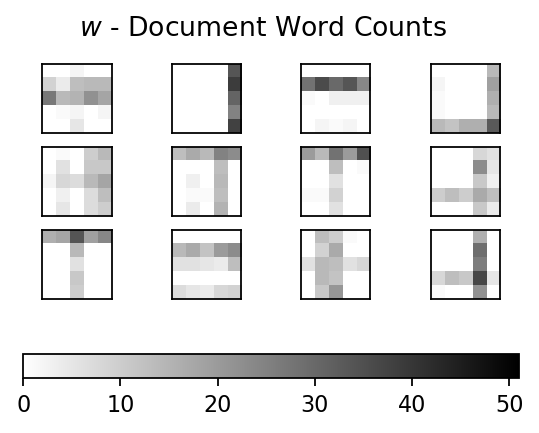

In [11]:
%matplotlib inline

fig = plot_lda(documents_training, nrows=3, ncols=4, cmap="gray_r", with_colorbar=True)
fig.suptitle("$w$ - Document Word Counts")
fig.set_dpi(160)

When taking a close look at these documents we can see some patterns in the word distributions suggesting that, perhaps, each topic represents a "column" or "row" of words with non-zero probability and that each document is composed primarily of a handful of topics.

Below we plots the *known* topic-word probability distributions, $\beta$. Similar to the documents we reshape each probability distribution to a $5 \times 5$ pixel image where the color represents the probability of that each word occurring in the topic.

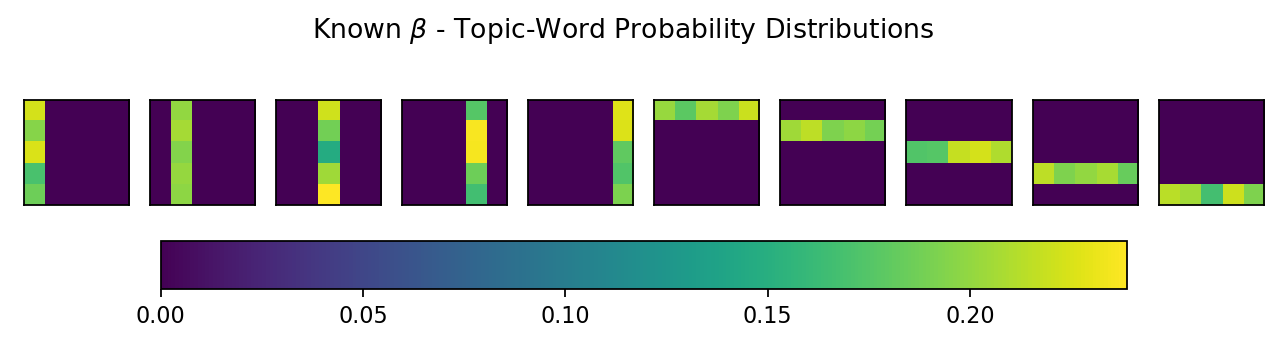

In [12]:
%matplotlib inline

fig = plot_lda(known_beta, nrows=1, ncols=10)
fig.suptitle(r"Known $\beta$ - Topic-Word Probability Distributions")
fig.set_dpi(160)
fig.set_figheight(2)

These 10 topics were used to generate the document corpus. Next, we will learn about how this is done.

## Generating Documents

LDA is a generative model, meaning that the LDA parameters $(\alpha, \beta)$ are used to construct documents word-by-word by drawing from the topic-word distributions. In fact, looking closely at the example documents above you can see that some documents sample more words from some topics than from others.

LDA works as follows: given 

* $M$ documents $w^{(1)}, w^{(2)}, \ldots, w^{(M)}$,
* an average document length of $N$,
* and an LDA model $(\alpha, \beta)$.

**For** each document, $w^{(m)}$:
* sample a topic mixture: $\theta^{(m)} \sim \text{Dirichlet}(\alpha)$
* **For** each word $n$ in the document:
  * Sample a topic $z_n^{(m)} \sim \text{Multinomial}\big( \theta^{(m)} \big)$
  * Sample a word from this topic, $w_n^{(m)} \sim \text{Multinomial}\big( \beta_{z_n^{(m)}} \; \big)$
  * Add to document

The [plate notation](https://en.wikipedia.org/wiki/Plate_notation) for the LDA model, introduced in [2], encapsulates this process pictorially.

![](http://scikit-learn.org/stable/_images/lda_model_graph.png)

> [2] David M Blei, Andrew Y Ng, and Michael I Jordan. Latent Dirichlet Allocation. Journal of Machine Learning Research, 3(Jan):993–1022, 2003.

## Topic Mixtures

For the documents we generated above lets look at their corresponding topic mixtures, $\theta \in \mathbb{R}^K$. The topic mixtures represent the probablility that a given word of the document is sampled from a particular topic. For example, if the topic mixture of an input document $w$ is,

$$\theta = \left[ 0.3, 0.2, 0, 0.5, 0, \ldots, 0 \right]$$

then $w$ is 30% generated from the first topic, 20% from the second topic, and 50% from the fourth topic. In particular, the words contained in the document are sampled from the first topic-word probability distribution 30% of the time, from the second distribution 20% of the time, and the fourth disribution 50% of the time.


The objective of inference, also known as scoring, is to determine the most likely topic mixture of a given input document. Colloquially, this means figuring out which topics appear within a given document and at what ratios. We will perform infernece later in the [Inference](#Inference) section.

Since we generated these example documents using the LDA model we know the topic mixture generating them. Let's examine these topic mixtures.

In [13]:
print("First training document =\n{}".format(documents_training[0]))
print("\nVocabulary size = {}".format(vocabulary_size))
print("Length of first document = {}".format(documents_training[0].sum()))

First training document =
[ 0.  0.  2.  0.  0.  9.  4. 13. 14. 14. 27. 14. 15. 22. 18.  0.  1.  2.
  0.  2.  0.  0.  5.  0.  0.]

Vocabulary size = 25
Length of first document = 162.0


In [14]:
print("First training document topic mixture =\n{}".format(topic_mixtures_training[0]))
print("\nNumber of topics = {}".format(num_topics))
print("sum(theta) = {}".format(topic_mixtures_training[0].sum()))

First training document topic mixture =
[0.    0.021 0.076 0.    0.002 0.    0.299 0.594 0.006 0.003]

Number of topics = 10
sum(theta) = 0.9999999999999998


We plot the first document along with its topic mixture. We also plot the topic-word probability distributions again for reference.

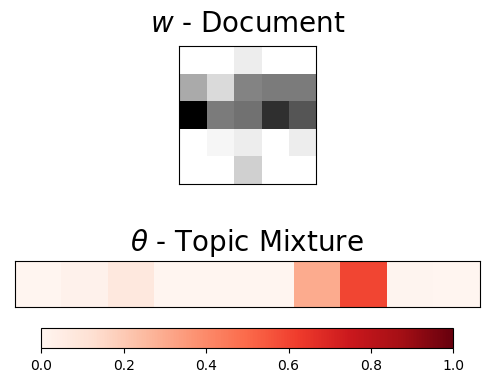

In [15]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.matshow(documents[0].reshape(5, 5), cmap="gray_r")
ax1.set_title(r"$w$ - Document", fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])

cax2 = ax2.matshow(topic_mixtures[0].reshape(1, -1), cmap="Reds", vmin=0, vmax=1)
cbar = fig.colorbar(cax2, orientation="horizontal")
ax2.set_title(r"$\theta$ - Topic Mixture", fontsize=20)
ax2.set_xticks([])
ax2.set_yticks([])

fig.set_dpi(100)

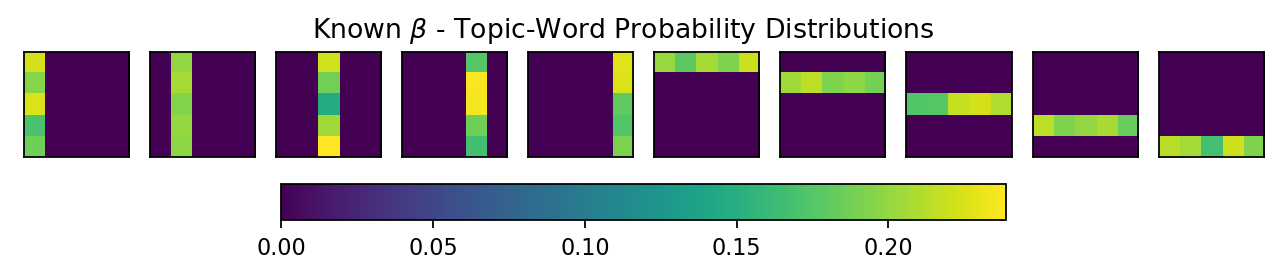

In [16]:
%matplotlib inline

# pot
fig = plot_lda(known_beta, nrows=1, ncols=10)
fig.suptitle(r"Known $\beta$ - Topic-Word Probability Distributions")
fig.set_dpi(160)
fig.set_figheight(1.5)

Finally, let's plot several documents with their corresponding topic mixtures. We can see how topics with large weight in the document lead to more words in the document within the corresponding "row" or "column".

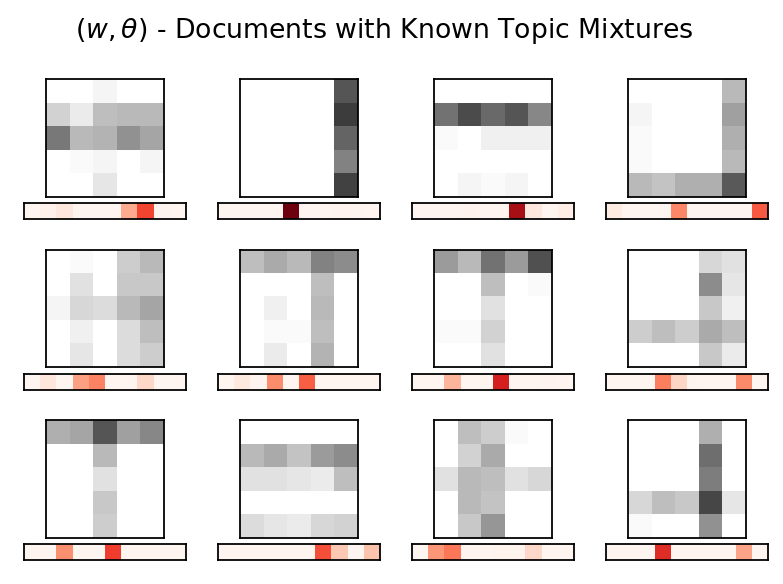

In [17]:
%matplotlib inline

fig = plot_lda_topics(documents_training, 3, 4, topic_mixtures=topic_mixtures)
fig.suptitle(r"$(w,\theta)$ - Documents with Known Topic Mixtures")
fig.set_dpi(160)

# Training

***

In this section we will give some insight into how AWS SageMaker LDA fits an LDA model to a corpus, create an run a SageMaker LDA training job, and examine the output trained model.

## Topic Estimation using Tensor Decompositions

Given a document corpus, Amazon SageMaker LDA uses a spectral tensor decomposition technique to determine the LDA model $(\alpha, \beta)$ which most likely describes the corpus. See [1] for a primary reference of the theory behind the algorithm. The spectral decomposition, itself, is computed using the CPDecomp algorithm described in [2].

The overall idea is the following: given a corpus of documents $\mathcal{W} = \{w^{(1)}, \ldots, w^{(M)}\}, \; w^{(m)} \in \mathbb{R}^V,$ we construct a statistic tensor,

$$T \in \bigotimes^3 \mathbb{R}^V$$

such that the spectral decomposition of the tensor is approximately the LDA parameters $\alpha \in \mathbb{R}^K$ and $\beta \in \mathbb{R}^{K \times V}$ which maximize the likelihood of observing the corpus for a given number of topics, $K$,

$$T \approx \sum_{k=1}^K \alpha_k \; (\beta_k \otimes \beta_k \otimes \beta_k)$$

This statistic tensor encapsulates information from the corpus such as the document mean, cross correlation, and higher order statistics. For details, see [1].


> [1] Animashree Anandkumar, Rong Ge, Daniel Hsu, Sham Kakade, and Matus Telgarsky. *"Tensor Decompositions for Learning Latent Variable Models"*, Journal of Machine Learning Research, 15:2773–2832, 2014.
>
> [2] Tamara Kolda and Brett Bader. *"Tensor Decompositions and Applications"*. SIAM Review, 51(3):455–500, 2009.




## Store Data on S3

Before we run training we need to prepare the data.

A SageMaker training job needs access to training data stored in an S3 bucket. Although training can accept data of various formats we convert the documents MXNet RecordIO Protobuf format before uploading to the S3 bucket defined at the beginning of this notebook.

In [28]:
# convert documents_training to Protobuf RecordIO format
recordio_protobuf_serializer = RecordSerializer()
fbuffer = recordio_protobuf_serializer.serialize(documents_training)

# upload to S3 in bucket/prefix/train
fname = "lda.data"
s3_object = os.path.join(prefix, "train", fname)
boto3.Session().resource("s3").Bucket(bucket).Object(s3_object).upload_fileobj(fbuffer)

s3_train_data = "s3://{}/{}".format(bucket, s3_object)
print("Uploaded data to S3: {}".format(s3_train_data))

Uploaded data to S3: s3://sagemaker-us-west-2-688520471316/sagemaker/DEMO-lda-science/train/lda.data


Next, we specify a Docker container containing the SageMaker LDA algorithm. For your convenience, a region-specific container is automatically chosen for you to minimize cross-region data communication

In [30]:
help(retrieve)

Help on function retrieve in module sagemaker.image_uris:

retrieve(framework, region, version=None, py_version=None, instance_type=None, accelerator_type=None, image_scope=None, container_version=None)
    Retrieves the ECR URI for the Docker image matching the given arguments.
    
    Args:
        framework (str): The name of the framework or algorithm.
        region (str): The AWS region.
        version (str): The framework or algorithm version. This is required if there is
            more than one supported version for the given framework or algorithm.
        py_version (str): The Python version. This is required if there is
            more than one supported Python version for the given framework version.
        instance_type (str): The SageMaker instance type. For supported types, see
            https://aws.amazon.com/sagemaker/pricing/instance-types. This is required if
            there are different images for different processor types.
        accelerator_type (str):

In [31]:
from sagemaker.image_uris import retrieve

region_name = boto3.Session().region_name
container = retrieve('lda', boto3.Session().region_name)

print("Using SageMaker LDA container: {} ({})".format(container, region_name))

Using SageMaker LDA container: 266724342769.dkr.ecr.us-west-2.amazonaws.com/lda:1 (us-west-2)


## Training Parameters

Particular to a SageMaker LDA training job are the following hyperparameters:

* **`num_topics`** - The number of topics or categories in the LDA model.
  * Usually, this is not known a priori.
  * In this example, howevever, we know that the data is generated by five topics.

* **`feature_dim`** - The size of the *"vocabulary"*, in LDA parlance.
  * In this example, this is equal 25.

* **`mini_batch_size`** - The number of input training documents.

* **`alpha0`** - *(optional)* a measurement of how "mixed" are the topic-mixtures.
  * When `alpha0` is small the data tends to be represented by one or few topics.
  * When `alpha0` is large the data tends to be an even combination of several or many topics.
  * The default value is `alpha0 = 1.0`.

In addition to these LDA model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.c4`
* Current limitations:
  * SageMaker LDA *training* can only run on a single instance.
  * SageMaker LDA does not take advantage of GPU hardware.
  * (The Amazon AI Algorithms team is working hard to provide these capabilities in a future release!)

Using the above configuration create a SageMaker client and use the client to create a training job.

In [32]:
session = sagemaker.Session()

# specify general training job information
lda = sagemaker.estimator.Estimator(
    container,
    role,
    output_path="s3://{}/{}/output".format(bucket, prefix),
    instance_count=1,
    instance_type="ml.c4.2xlarge",
    sagemaker_session=session,
)

# set algorithm-specific hyperparameters
lda.set_hyperparameters(
    num_topics=num_topics,
    feature_dim=vocabulary_size,
    mini_batch_size=num_documents_training,
    alpha0=1.0,
)

# run the training job on input data stored in S3
lda.fit({"train": s3_train_data})

2021-05-13 21:10:59 Starting - Starting the training job...
2021-05-13 21:11:01 Starting - Launching requested ML instances.........
2021-05-13 21:12:31 Starting - Preparing the instances for training...
2021-05-13 21:13:25 Downloading - Downloading input data...
2021-05-13 21:13:36 Training - Downloading the training image......
2021-05-13 21:14:46 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Using mxnet backend.
[05/13/2021 21:14:49 INFO 139817151432512] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'alpha0': u'1.0', u'max_restarts': u'10', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'allow_svd_init': u'true', u'epochs': u'1', u'tol': u'1e-8', u'_kvstore': u'local', u'max_iterations': u'1000'}
[05/13/2021 21:14:49 INFO 139817151432512] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': 

If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training sucessfully completed and the output LDA model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [33]:
print("Training job name: {}".format(lda.latest_training_job.job_name))

Training job name: lda-2021-05-13-21-10-59-699


## Inspecting the Trained Model

We know the LDA parameters $(\alpha, \beta)$ used to generate the example data. How does the learned model compare the known one? In this section we will download the model data and measure how well SageMaker LDA did in learning the model.

First, we download the model data. SageMaker will output the model in 

> `s3://<bucket>/<prefix>/output/<training job name>/output/model.tar.gz`.

SageMaker LDA stores the model as a two-tuple $(\alpha, \beta)$ where each LDA parameter is an MXNet NDArray.

In [34]:
# download and extract the model file from S3
job_name = lda.latest_training_job.job_name
model_fname = "model.tar.gz"
model_object = os.path.join(prefix, "output", job_name, "output", model_fname)
boto3.Session().resource("s3").Bucket(bucket).Object(model_object).download_file(fname)
with tarfile.open(fname) as tar:
    tar.extractall()
print("Downloaded and extracted model tarball: {}".format(model_object))

# obtain the model file
model_list = [fname for fname in os.listdir(".") if fname.startswith("model_")]
model_fname = model_list[0]
print("Found model file: {}".format(model_fname))

# get the model from the model file and store in Numpy arrays
alpha, beta = mx.ndarray.load(model_fname)
learned_alpha_permuted = alpha.asnumpy()
learned_beta_permuted = beta.asnumpy()

print("\nLearned alpha.shape = {}".format(learned_alpha_permuted.shape))
print("Learned beta.shape = {}".format(learned_beta_permuted.shape))

Downloaded and extracted model tarball: sagemaker/DEMO-lda-science/output/lda-2021-05-13-21-10-59-699/output/model.tar.gz
Found model file: model_algo-1

Learned alpha.shape = (10,)
Learned beta.shape = (10, 25)


Presumably, SageMaker LDA has found the topics most likely used to generate the training corpus. However, even if this is case the topics would not be returned in any particular order. Therefore, we match the found topics to the known topics closest in L1-norm in order to find the topic permutation.

Note that we will use the `permutation` later during inference to match known topic mixtures to found topic mixtures.

Below plot the known topic-word probability distribution, $\beta \in \mathbb{R}^{K \times V}$ next to the distributions found by SageMaker LDA as well as the L1-norm errors between the two.

L1-error (beta) = 0.17260464746380463
L1-error (alpha) = 0.15227436721324922


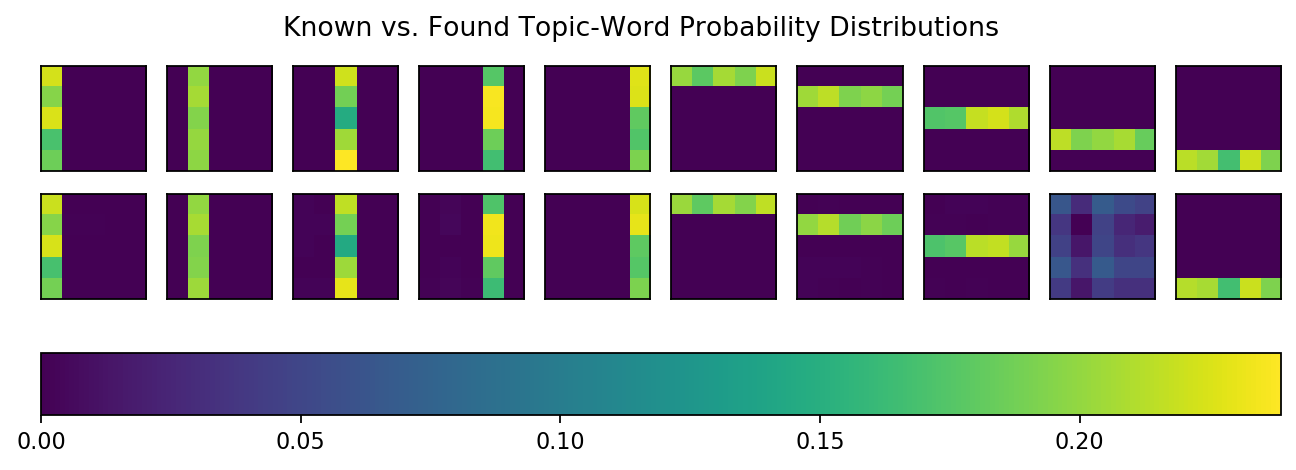

In [35]:
permutation, learned_beta = match_estimated_topics(known_beta, learned_beta_permuted)
learned_alpha = learned_alpha_permuted[permutation]

fig = plot_lda(np.vstack([known_beta, learned_beta]), 2, 10)
fig.set_dpi(160)
fig.suptitle("Known vs. Found Topic-Word Probability Distributions")
fig.set_figheight(3)

beta_error = np.linalg.norm(known_beta - learned_beta, 1)
alpha_error = np.linalg.norm(known_alpha - learned_alpha, 1)
print("L1-error (beta) = {}".format(beta_error))
print("L1-error (alpha) = {}".format(alpha_error))

Not bad!

In the eyeball-norm the topics match quite well. In fact, the topic-word distribution error is approximately 2%.

# Inference

***

A trained model does nothing on its own. We now want to use the model we computed to perform inference on data. For this example, that means predicting the topic mixture representing a given document.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

With this realtime endpoint at our fingertips we can finally perform inference on our training and test data.

We can pass a variety of data formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted, JSON-sparse-formatter, and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `CSVSerializer` and `JSONDeserializer` when configuring the inference endpoint.

In [44]:
lda_inference = lda.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge", # LDA inference may work better at scale on ml.c4 instances
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
)

---------------!

Congratulations! You now have a functioning SageMaker LDA inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [48]:
print("Endpoint name: {}".format(lda_inference.endpoint_name))

Endpoint name: lda-2021-05-13-21-21-19-026


We pass some test documents to the inference endpoint. Note that the serializer and deserializer will atuomatically take care of the datatype conversion.

In [50]:
results = lda_inference.predict(documents_test[:12])

print(results)

{'predictions': [{'topic_mixture': [0.0, 0.09566821157932281, 0.0, 0.9043317437171936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.29417216777801514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21673372387886047, 0.2874864637851715, 0.2016075849533081]}, {'topic_mixture': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.062422290444374084, 0.08510737121105194, 0.0, 0.0, 0.0, 0.0, 0.0, 0.852470338344574, 0.0, 0.0]}, {'topic_mixture': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.0, 0.6618881225585938, 0.0, 0.12934377789497375, 0.0, 0.0, 0.0, 0.20876812934875488, 0.0, 0.0]}, {'topic_mixture': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9051477909088135, 0.09485216438770294, 0.0]}, {'topic_mixture': [0.0, 0.0, 0.0, 0.0, 0.0, 0.028457581996917725, 0.4587487280368805, 0.0, 0.512793779373169, 0.0]}, {'topic_mixture': [0.07738880813121796, 0.09227049350738525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8122768402099609, 0.018063843250274658]}, {'topic_mixture'

It may be hard to see but the output format of SageMaker LDA inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    ...
  ]
}
```

We extract the topic mixtures, themselves, corresponding to each of the input documents.

In [51]:
inferred_topic_mixtures_permuted = np.array(
    [prediction["topic_mixture"] for prediction in results["predictions"]]
)

print("Inferred topic mixtures (permuted):\n\n{}".format(inferred_topic_mixtures_permuted))

Inferred topic mixtures (permuted):

[[0.    0.096 0.    0.904 0.    0.    0.    0.    0.    0.   ]
 [0.294 0.    0.    0.    0.    0.    0.    0.217 0.287 0.202]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.062 0.085 0.    0.    0.    0.    0.    0.852 0.    0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.662 0.    0.129 0.    0.    0.    0.209 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.905 0.095 0.   ]
 [0.    0.    0.    0.    0.    0.028 0.459 0.    0.513 0.   ]
 [0.077 0.092 0.    0.    0.    0.    0.    0.    0.812 0.018]
 [0.035 0.    0.588 0.274 0.    0.    0.    0.    0.    0.102]
 [0.    0.    0.    0.    0.681 0.    0.319 0.    0.    0.   ]
 [0.142 0.    0.    0.048 0.166 0.16  0.484 0.    0.    0.   ]]


## Inference Analysis

Recall that although SageMaker LDA successfully learned the underlying topics which generated the sample data the topics were in a different order. Before we compare to known topic mixtures $\theta \in \mathbb{R}^K$ we should also permute the inferred topic mixtures


In [52]:
inferred_topic_mixtures = inferred_topic_mixtures_permuted[:, permutation]

print("Inferred topic mixtures:\n\n{}".format(inferred_topic_mixtures))

Inferred topic mixtures:

[[0.    0.    0.    0.    0.    0.904 0.    0.096 0.    0.   ]
 [0.    0.202 0.    0.    0.217 0.    0.    0.    0.294 0.287]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.852 0.    0.    0.085 0.062 0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.209 0.129 0.    0.662 0.    0.   ]
 [0.    0.    0.    0.    0.905 0.    0.    0.    0.    0.095]
 [0.    0.    0.028 0.    0.    0.    0.459 0.    0.    0.513]
 [0.    0.018 0.    0.    0.    0.    0.    0.092 0.077 0.812]
 [0.    0.102 0.    0.588 0.    0.274 0.    0.    0.035 0.   ]
 [0.681 0.    0.    0.    0.    0.    0.319 0.    0.    0.   ]
 [0.166 0.    0.16  0.    0.    0.048 0.484 0.    0.142 0.   ]]


Let's plot these topic mixture probability distributions alongside the known ones.

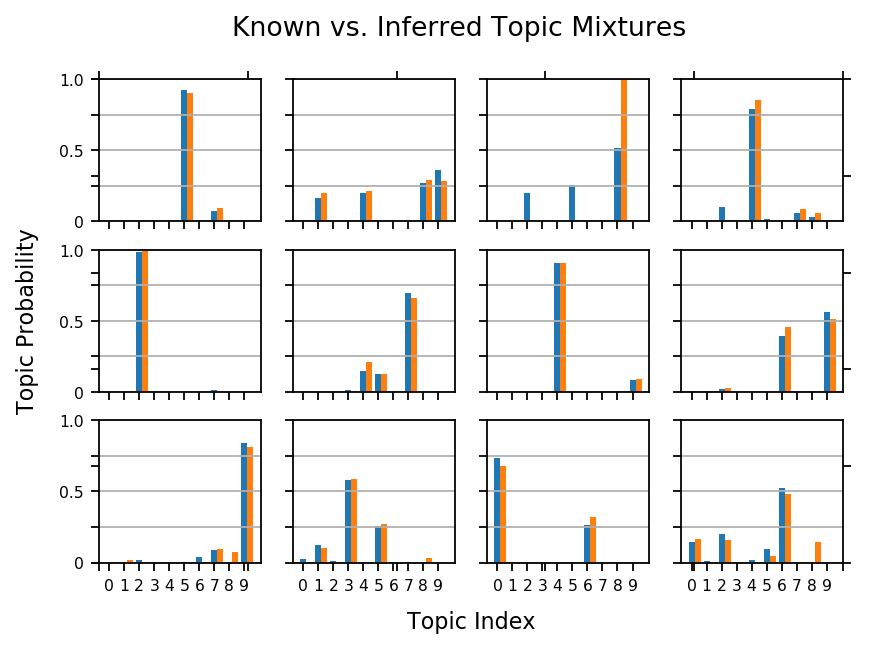

In [53]:
%matplotlib inline

# create array of bar plots
width = 0.4
x = np.arange(10)

nrows, ncols = 3, 4
fig, ax = plt.subplots(nrows, ncols, sharey=True)
for i in range(nrows):
    for j in range(ncols):
        index = i * ncols + j
        ax[i, j].bar(x, topic_mixtures_test[index], width, color="C0")
        ax[i, j].bar(x + width, inferred_topic_mixtures[index], width, color="C1")
        ax[i, j].set_xticks(range(num_topics))
        ax[i, j].set_yticks(np.linspace(0, 1, 5))
        ax[i, j].grid(which="major", axis="y")
        ax[i, j].set_ylim([0, 1])
        ax[i, j].set_xticklabels([])
        if i == (nrows - 1):
            ax[i, j].set_xticklabels(range(num_topics), fontsize=7)
        if j == 0:
            ax[i, j].set_yticklabels([0, "", 0.5, "", 1.0], fontsize=7)

fig.suptitle("Known vs. Inferred Topic Mixtures")
ax_super = fig.add_subplot(111, frameon=False)
ax_super.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
ax_super.grid(False)
ax_super.set_xlabel("Topic Index")
ax_super.set_ylabel("Topic Probability")
fig.set_dpi(160)

In the eyeball-norm these look quite comparable.

Let's be more scientific about this. Below we compute and plot the distribution of L1-errors from **all** of the test documents. Note that we send a new payload of test documents to the inference endpoint and apply the appropriate permutation to the output.

In [54]:
%%time

# create a payload containing all of the test documents and run inference again
#
# TRY THIS:
#   try switching between the test data set and a subset of the training
#   data set. It is likely that LDA inference will perform better against
#   the training set than the holdout test set.
#
payload_documents = documents_test  # Example 1
known_topic_mixtures = topic_mixtures_test  # Example 1
# payload_documents = documents_training[:600];         # Example 2
# known_topic_mixtures = topic_mixtures_training[:600]  # Example 2

print("Invoking endpoint...\n")
results = lda_inference.predict(payload_documents)

inferred_topic_mixtures_permuted = np.array(
    [prediction["topic_mixture"] for prediction in results["predictions"]]
)
inferred_topic_mixtures = inferred_topic_mixtures_permuted[:, permutation]

print("known_topics_mixtures.shape = {}".format(known_topic_mixtures.shape))
print("inferred_topics_mixtures_test.shape = {}\n".format(inferred_topic_mixtures.shape))

Invoking endpoint...

known_topics_mixtures.shape = (600, 10)
inferred_topics_mixtures_test.shape = (600, 10)

CPU times: user 14.4 ms, sys: 12 ms, total: 26.4 ms
Wall time: 10.2 s


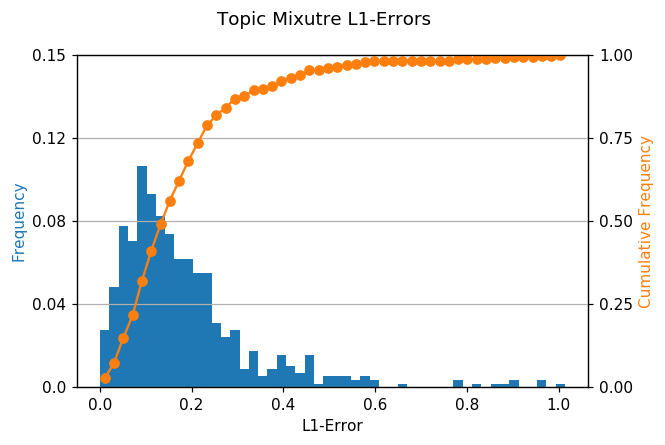

In [61]:
%matplotlib inline

l1_errors = np.linalg.norm((inferred_topic_mixtures - known_topic_mixtures), 1, axis=1)

# plot the error freqency
fig, ax_frequency = plt.subplots()
bins = np.linspace(0, 1, 40)
weights = np.ones_like(l1_errors) / len(l1_errors)
freq, bins, _ = ax_frequency.hist(l1_errors, bins=50, weights=weights, color="C0")
ax_frequency.set_xlabel("L1-Error")
ax_frequency.set_ylabel("Frequency", color="C0")


# plot the cumulative error
shift = (bins[1] - bins[0]) / 2
x = bins[1:] - shift
ax_cumulative = ax_frequency.twinx()
cumulative = np.cumsum(freq) / sum(freq)
ax_cumulative.plot(x, cumulative, marker="o", color="C1")
ax_cumulative.set_ylabel("Cumulative Frequency", color="C1")


# align grids and show
freq_ticks = np.linspace(0, 1.5 * freq.max(), 5)
freq_ticklabels = np.round(100 * freq_ticks) / 100
ax_frequency.set_yticks(freq_ticks)
ax_frequency.set_yticklabels(freq_ticklabels)
ax_cumulative.set_yticks(np.linspace(0, 1, 5))
ax_cumulative.grid(which="major", axis="y")
ax_cumulative.set_ylim((0, 1))


fig.suptitle("Topic Mixutre L1-Errors")
fig.set_dpi(110)

Machine learning algorithms are not perfect and the data above suggests this is true of SageMaker LDA. With more documents and some hyperparameter tuning we can obtain more accurate results against the known topic-mixtures.

For now, let's just investigate the documents-topic mixture pairs that seem to do well as well as those that do not. Below we retreive a document and topic mixture corresponding to a small L1-error as well as one with a large L1-error.

In [56]:
N = 6

good_idx = l1_errors < 0.05
good_documents = payload_documents[good_idx][:N]
good_topic_mixtures = inferred_topic_mixtures[good_idx][:N]

poor_idx = l1_errors > 0.3
poor_documents = payload_documents[poor_idx][:N]
poor_topic_mixtures = inferred_topic_mixtures[poor_idx][:N]

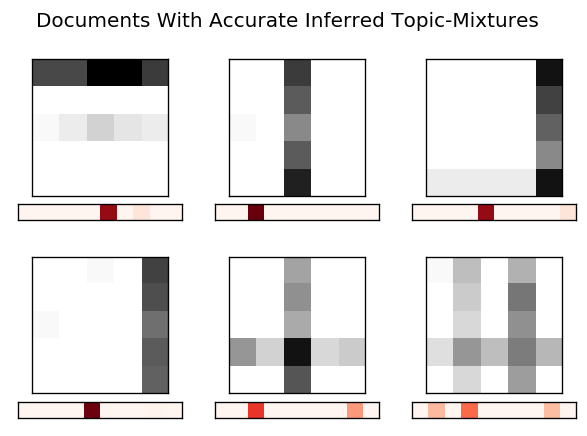

In [57]:
%matplotlib inline

fig = plot_lda_topics(good_documents, 2, 3, topic_mixtures=good_topic_mixtures)
fig.suptitle("Documents With Accurate Inferred Topic-Mixtures")
fig.set_dpi(120)

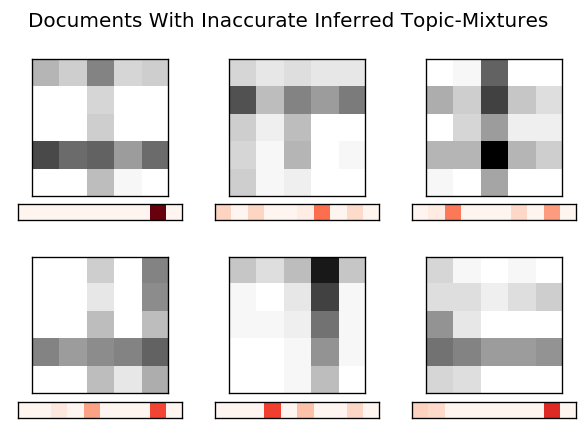

In [58]:
%matplotlib inline

fig = plot_lda_topics(poor_documents, 2, 3, topic_mixtures=poor_topic_mixtures)
fig.suptitle("Documents With Inaccurate Inferred Topic-Mixtures")
fig.set_dpi(120)

In this example set the documents on which inference was not as accurate tend to have a denser topic-mixture. This makes sense when extrapolated to real-world datasets: it can be difficult to nail down which topics are represented in a document when the document uses words from a large subset of the vocabulary.

## Stop / Close the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

# Epilogue

---

In this notebook we,

* learned about the LDA model,
* generated some example LDA documents and their corresponding topic-mixtures,
* trained a SageMaker LDA model on a training set of documents and compared the learned model to the known model,
* created an inference endpoint,
* used the endpoint to infer the topic mixtures of a test input and analyzed the inference error.

There are several things to keep in mind when applying SageMaker LDA to real-word data such as a corpus of text documents. Note that input documents to the algorithm, both in training and inference, need to be vectors of integers representing word counts. Each index corresponds to a word in the corpus vocabulary. Therefore, one will need to "tokenize" their corpus vocabulary.

$$
\text{"cat"} \mapsto 0, \; \text{"dog"} \mapsto 1 \; \text{"bird"} \mapsto 2, \ldots
$$

Each text document then needs to be converted to a "bag-of-words" format document.

$$
w = \text{"cat bird bird bird cat"} \quad \longmapsto \quad w = [2, 0, 3, 0, \ldots, 0]
$$

Also note that many real-word applications have large vocabulary sizes. It may be necessary to represent the input documents in sparse format. Finally, the use of stemming and lemmatization in data preprocessing provides several benefits. Doing so can improve training and inference compute time since it reduces the effective vocabulary size. More importantly, though, it can improve the quality of learned topic-word probability matrices and inferred topic mixtures. For example, the words *"parliament"*, *"parliaments"*, *"parliamentary"*, *"parliament's"*, and *"parliamentarians"* are all essentially the same word, *"parliament"*, but with different conjugations. For the purposes of detecting topics, such as a *"politics"* or *governments"* topic, the inclusion of all five does not add much additional value as they all essentiall describe the same feature.